## Approach 5 for clustering similar test steps in natural language

* Text embedding technique: TF-IDF is used to obtain a numeric representation for sentences
* Text similarity: Cosine
* Clustering techniques: Hierarchical agglomerative clustering and K-means

In [1]:
# Import necessary libraries
import os
import gc
import pandas as pd
import numpy as np
import math
import statistics as st
import re
import string
import json
import time
import matplotlib.pyplot as plt

# For word frequency
from collections import defaultdict

# ML libraries
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import scipy.cluster.hierarchy as sch
import gensim
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.corpora.dictionary import Dictionary
import tensorflow as tf
import tensorflow_hub as hub


# NLP libraries
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer 

# To be used with hierarchical clustering
from joblib import Memory

# To save models
import pickle

In [ ]:
# Download wordnet data through nltk
nltk.download('wordnet')

### Data preprocessing functions

In [6]:
# Function to compute number of unique words in df
def get_number_unique_words(df):
    words_list = list()
    test_steps = list(df["Steps"])
    for step in test_steps:
        for word in step:
            words_list.append(word)
    number_unique_words = len(set(words_list))
    return number_unique_words

In [7]:
# Function to compute number of unique words in df ('test case name' field)
def get_number_unique_words_name(df):
    words_list = list()
    test_names = list(df["Case_Name"])
    for name in test_names:
        for word in name:
            words_list.append(word)
    number_unique_words = len(set(words_list))
    return number_unique_words

In [8]:
# Function to get list of words that occur less than a certain number of times
def get_word_frequency(df):
    words_list = list()
    test_steps = list(df["Steps"])
    for step in test_steps:
        for word in step:
            words_list.append(word)
    unique_words_list = set(words_list)
    word_occurrence_dict = {}
    for each_word in unique_words_list:
        word_occurrence_dict[each_word] = 0

    for step in test_steps:
        for word in step:
            word_occurrence_dict[word] += 1
            
    ten_times_occurrence_words = list()
    # get list of words that occur only once
    for word, occurrence in word_occurrence_dict.items():
        if occurrence < 2:
            ten_times_occurrence_words.append(word)

    return ten_times_occurrence_words

In [9]:
# Function to get list of words that occur less than a certain number of times ('test case name' field)
def get_word_frequency_name(df):
    words_list = list()
    test_names = list(df["Case_Name"])
    for name in test_names:
        for word in name:
            words_list.append(word)
    unique_words_list = set(words_list)
    word_occurrence_dict = {}
    for each_word in unique_words_list:
        word_occurrence_dict[each_word] = 0

    for name in test_names:
        for word in name:
            word_occurrence_dict[word] += 1
            
    ten_times_occurrence_words = list()
    # get list of words that occur only once
    for word, occurrence in word_occurrence_dict.items():
        if occurrence < 2:
            ten_times_occurrence_words.append(word)

    return ten_times_occurrence_words

In [10]:
# Function to remove problematic/mispelled words from vocabulary
def remove_problematic_words(df):
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps: ", number_unique_words)
    
    # load file with problematic words that exist in the test data
    problematic_words = open('word2vec_vocab_problematic.txt', 'r')
    problematic_words_list = list()
    for word in problematic_words:
        problematic_words_list.append(word.lstrip().rstrip())
    
    for index, row in df.iterrows():
        step = row["Steps"]
        df.loc[index]["Steps"] = [elem for elem in step if not elem in problematic_words_list]
        
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps after removing problematic words: ", number_unique_words)

In [11]:
# function to fix problematic/mispelled words from vocabulary
def fix_problematic_words(df):
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps: ", number_unique_words)
    
    # load file with problematic words that exist in the test data
    problematic_words = open('word2vec_vocab_to_fix.txt', 'r')
    problematic_words_dict = {}
    for line in problematic_words:
        full_line = line.split(':')
        try:
            problematic_words_dict[full_line[0]] = [x.replace('\n', '') for x in full_line[1].split(',')]
        except:
            problematic_words_dict[full_line[0]] = full_line[1].replace('\n', '')
    
    for index, row in df.iterrows():
        step = row["Steps"]
        modified_step = list()
        for word in step:
            if word in problematic_words_dict:
                modified_step.extend(problematic_words_dict[word])
            else:
                modified_step.append(word)
        df.loc[index]["Steps"] = modified_step 
        
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps after fixing problematic words: ", number_unique_words)

In [8]:
def preprocess_clean_data(df):

    # Preprocessing and clean test steps
    print("Cleaning test step field...")
    
    df["Steps"] = df["Steps"].apply(lambda x: re.sub(r'http\S+', 'URL', x))
    df["Steps"] = df["Steps"].apply(lambda x: re.sub('\/[\w-]*', '', x))
    df["Steps"] = df["Steps"].apply(lambda x: re.sub(r'\{[^)]*\}', '', x))

    # lowercase the step descriptions
    df["Steps"] = df["Steps"].apply(lambda x: x.lower())

    # remove digits and words with digits
    df["Steps"] = df["Steps"].apply(lambda x: re.sub('\w*\d\w*','', x))

    # remove punctuations
    df["Steps"] = df["Steps"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

    # remove extra spaces
    df["Steps"] = df["Steps"].apply(lambda x: re.sub(' +',' ',x))

    # tokenization
    df["Steps"] = df["Steps"].apply(lambda x: TweetTokenizer().tokenize(x))
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps: ", number_unique_words)

    remove_problematic_words(df)
    fix_problematic_words(df)
    
    # stopword removal
    stop_words = set(stopwords.words('english'))
    df["Steps"] = df["Steps"].apply(lambda x: [w for w in x if not w in stop_words])
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words in test steps after stopword removal: ", number_unique_words)

    # lemmatization
    lemmatizer = WordNetLemmatizer() 
    df["Steps"] = df["Steps"].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words in test steps after lemmatization: ", number_unique_words)

    # remove words that occur less than 10 times
    ten_times_occurrence_words = get_word_frequency(df)
    print("Number of words that occurred less than 10 times in test steps: ", len(ten_times_occurrence_words))

    for index, row in df.iterrows():
        current_test_step = row["Steps"]
        list_words_to_remove = list()
        for word in current_test_step:
            if word in ten_times_occurrence_words:
                list_words_to_remove.append(word)

        test_steps_df.loc[index]["Steps"] = [elem for elem in current_test_step if not elem in list_words_to_remove]

    print("Dataset size after preprocessing: " , df.shape)

### Read and preprocess files with test cases and build dataframe

In [20]:
# Get data directory and list of xlsx files
current_dir = os.getcwd() 
parent_dir = os.path.dirname(current_dir) + "\\filtered_data\\"
xlsxfiles = [os.path.join(root, name)
             for root, dirs, files in os.walk(parent_dir)
             for name in files
             if name.endswith((".xlsx"))]

In [ ]:
# Declare pandas df to be populated
column_names = ["Type", "Key", "Case_Name", "Step_ID", "Steps"]
test_steps_df = pd.DataFrame(columns = column_names)

# Index to add data to the df
index_to_add = 0

print("Reading input data...")   
for test_file in xlsxfiles:
    # load data and iterate through it
    test_data_df = pd.read_excel(test_file)
    for index, row in test_data_df.iterrows():
        current_type = row["Type"]
        current_key = row["Key"]
        current_name = row["Case_Name"]
        current_step_id = row["Step_ID"]
        current_steps = row["Steps"]
        test_steps_df.loc[index_to_add] = [current_type, current_key, current_name, current_step_id, current_steps]
        index_to_add += 1

print("Done!")
print("Shape of data => ", test_steps_df.shape)

In [ ]:
# Call preprocessing function
preprocess_clean_data(test_steps_df)

In [ ]:
# Build tuples with (step_id, step_text) - used to retrieve the step ID in the end (after the clustering) - and get only test steps for clustering
step_id_text_tuple_list = list()
test_steps_clustering_list = list()
for index, row in test_steps_df.iterrows():
    step_id = row["Step_ID"]
    step_text = row["Steps"]
    step_id_text_tuple_list.append((step_id,step_text))

    temp_list = list()
    if isinstance(row["Steps"], list):
        for elem in row["Steps"]:
            temp_list.append(elem)
    else:
        if isinstance(row["Steps"], str):
            temp_list.append(row["Steps"])
        
    # Build list of lists of tokens (words)
    test_steps_clustering_list.append(temp_list)
    
print("Length of list of tuples:" , len(step_id_text_tuple_list))
print("Length of list with test steps: " , len(test_steps_clustering_list))

In [ ]:
# Remove empty steps
index = 0
steps_to_remove = list()
for step in test_steps_clustering_list:
    if len(step) == 0:
        steps_to_remove.append(index)
    index += 1

step_id_text_tuple_list = [step_id_text_tuple_list[index] for index in range(len(step_id_text_tuple_list)) if not index in steps_to_remove]
test_steps_clustering_list = [test_steps_clustering_list[index] for index in range(len(test_steps_clustering_list)) if not index in steps_to_remove]
print("Length of list of tuples:" , len(step_id_text_tuple_list))
print("Length of list with test steps: " , len(test_steps_clustering_list))

### Compute TF-IDF

In [24]:
test_steps_tf_idf_list = list()
for index in range(len(test_steps_clustering_list)):
    test_steps_tf_idf_list.append(' '.join(test_steps_clustering_list[index]))
print("Length of list with test steps: " , len(test_steps_tf_idf_list))

Length of list with test steps:  15644


In [26]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(test_steps_tf_idf_list)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
test_steps_tfidf_df = pd.DataFrame(denselist, columns=feature_names)

In [27]:
tf_idf_embeddings_list = list()
for index in range(len(test_steps_tfidf_df)):
    tf_idf_embeddings_list.append(np.array(test_steps_tfidf_df.loc[index].tolist()))

In [ ]:
# Print a few examples 
ex1 = [(i, e) for i, e in enumerate(tf_idf_embeddings_list[2044]) if e != 0]
ex2 = [(i, e) for i, e in enumerate(tf_idf_embeddings_list[2050]) if e != 0]
print(ex1)
print(ex2)

In [35]:
# Convert list to np array
tf_idf_embeddings_list_numpy = np.array(tf_idf_embeddings_list)

# Keep tensor version to compute cosine similarity
tf_idf_embeddings_list_tensor = torch.from_numpy(tf_idf_embeddings_list_numpy)

In [39]:
tf_idf_embeddings_list_tensor.shape

torch.Size([15644, 1740])

### Compute distance between steps

In [43]:
# Compute distance using tensor
cosine_dist_matrix_tensor = 1 - util.pytorch_cos_sim(tf_idf_embeddings_list_tensor, tf_idf_embeddings_list_tensor)

In [44]:
# Convert back to numpy
cosine_dist_matrix = cosine_dist_matrix_tensor.numpy()

In [60]:
# save distance matrix
np.savetxt("appr_5_dist_matrix.txt", cosine_dist_matrix)

# # to load
# cosine_dist_matrix = np.loadtxt("appr_5_dist_matrix.txt")

### Execute hierarchical agglomerative clustering and K-means

#### Load ground truth of similar test steps (to compute F-score)

In [34]:
# Read excel files with ground truth of similar test steps (cannot be released due to sensitive information)
ground_truth_dir = 'sample_manual_ground_truth/clusters/'
sample_files = os.listdir(ground_truth_dir)

In [35]:
manual_clusters_dict = {}
for sample in sample_files:
    sample_df = pd.read_excel(manual_sample_dir + sample)
    for index, row in sample_df.iterrows():
        cluster_id = row['cluster_id']
        step_id = row['step_id']
        if step_id in manual_clusters_dict:
            existing_list = manual_clusters_dict[step_id]
            existing_list.append(cluster_id)
            manual_clusters_dict[step_id] = existing_list
        else:
            manual_clusters_dict[step_id] = [cluster_id]

In [ ]:
print("Number of test step samples which were manually clustered: ", len(manual_clusters_dict))

In [37]:
test_steps_to_evaluate_list = list(manual_clusters_dict.keys())

In [ ]:
# Use f-score to tune number of clusters and evaluation
aggl_model_list = list()
kmeans_model_list = list()
f_score_aggl_list = list()
f_score_kmeans_list = list()

start = time.time()

for num_clusters in range(50, 15001, 50):
    start = time.time()
    print("Running for: " + str(num_clusters) + " clusters")
    aggl_clustering_model = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='average', memory=Memory('/tmp/memory_cache'))
    aggl_clustering_model.fit(cosine_dist_matrix)
    aggl_model_list.append(aggl_clustering_model)
    labels = aggl_clustering_model.labels_
    
    # Compute f-score - declare and initialize variables to compute F-score
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    appr_clusters_dict = {}
    for single_label in set(labels):
        indices_label = np.where(labels == single_label)[0].tolist()
        for ind in indices_label:
            appr_clusters_dict[int(step_id_text_tuple_list[ind][0])] = single_label
        
    # Iterate through list of test steps to evaluate
    for i in range(len(test_steps_to_evaluate_list)-1):
        for j in range(i+1, len(test_steps_to_evaluate_list)):
            step_id_1 = test_steps_to_evaluate_list[i]
            step_id_2 = test_steps_to_evaluate_list[j]

            # true positive case
            if (manual_clusters_dict[step_id_1] == manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] == appr_clusters_dict[step_id_2]):
                TP += 1

            # false positive case
            elif (manual_clusters_dict[step_id_1] != manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] == appr_clusters_dict[step_id_2]):
                FP += 1

            # false negative case
            elif (manual_clusters_dict[step_id_1] == manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] != appr_clusters_dict[step_id_2]):
                FN += 1

            # true negative case
            elif (manual_clusters_dict[step_id_1] != manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] != appr_clusters_dict[step_id_2]):
                TN += 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = (2 * precision * recall) / (precision + recall)
    f_score_aggl_list.append(f_score)
    
    # Declare and initialize numpy ndarray for k means centroid initialization with shape: [n_clusters, n_features]
    init_centroid_kmeans = np.zeros((num_clusters,1740))

    for single_label in set(labels):
        indices_label = np.where(labels == single_label)[0].tolist()
        sent_vectors_list = [tf_idf_embeddings_list[ind] for ind in indices_label]

        # compute average sentence vector between the selected sentences in 'sent_vectors_list'
        avg_sent_vectors = sum(sent_vectors_list)/len(sent_vectors_list)
        init_centroid_kmeans[single_label,:] = avg_sent_vectors    
    
    # Run K-Means with the computed centroids
    kmeans = KMeans(n_clusters=num_clusters, init=init_centroid_kmeans, max_iter=300)
    kmeans.fit(tf_idf_embeddings_list)
    kmeans_model_list.append(kmeans)
    labels = kmeans.labels_
    
    # Compute f-score - declare and initialize variables to compute F-score
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    appr_clusters_dict = {}
    for single_label in set(labels):
        indices_label = np.where(labels == single_label)[0].tolist()
        for ind in indices_label:
            appr_clusters_dict[int(step_id_text_tuple_list[ind][0])] = single_label
        
    # Iterate through list of steps to evaluate
    for i in range(len(test_steps_to_evaluate_list)-1):
        for j in range(i+1, len(test_steps_to_evaluate_list)):
            step_id_1 = test_steps_to_evaluate_list[i]
            step_id_2 = test_steps_to_evaluate_list[j]

            # true positive case
            if (manual_clusters_dict[step_id_1] == manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] == appr_clusters_dict[step_id_2]):
                TP += 1

            # false positive case
            elif (manual_clusters_dict[step_id_1] != manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] == appr_clusters_dict[step_id_2]):
                FP += 1

            # false negative case
            elif (manual_clusters_dict[step_id_1] == manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] != appr_clusters_dict[step_id_2]):
                FN += 1

            # true negative case
            elif (manual_clusters_dict[step_id_1] != manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] != appr_clusters_dict[step_id_2]):
                TN += 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = (2 * precision * recall) / (precision + recall)
    f_score_kmeans_list.append(f_score)    
    
    # Delete unnecessary variables to free memory up
    del aggl_clustering_model
    del kmeans
    
    end = time.time()
    print(f'Finished in {round(end-start,2)} second(s)')

### Analysis of hierarhical agglomerative clustering

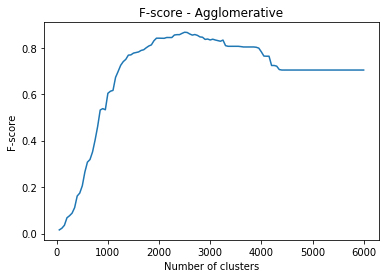

In [68]:
# Plot F-score against number of clusters
plt.plot(list(range(50, 15001, 50)), f_score_aggl_list)
plt.title('F-score - Agglomerative')
plt.xlabel('Number of clusters')
plt.ylabel('F-score')
plt.show()

In [ ]:
# Find max F-score and corresponding index
max_score = max(f_score_aggl_list)
max_index = f_score_aggl_list.index(max_score)
print("Best F-score: " , max_score)
print("Index of best F-score: ", max_index)

In [ ]:
best_aggl_model = aggl_model_list[max_index]

In [ ]:
# Get number of clusters of the best model
best_aggl_model_num_clusters = best_aggl_model.n_clusters
best_aggl_model_labels = best_aggl_model.labels_
print("Number of clusters of the best agglomerative model: ", best_aggl_model_num_clusters)

In [ ]:
# save clustered data
path_to_save_data = "appr_5_clustered_data.txt"
out_cluster_file = open(path_to_save_data, "a")
for single_label in set(best_aggl_model_labels):
    indices_label = np.where(best_aggl_model_labels == single_label)[0].tolist()
    for index in indices_label:
        str_to_save = "[" + str(single_label) + "]:\t\t" + test_steps_df.loc[index]["Key"] + "\t\t" + str(step_id_text_tuple_list[index][0]) + "\t\t"+ str(test_steps_clustering_list[index]) + "\n"
        out_cluster_file.write(str_to_save)
out_cluster_file.close()

In [ ]:
# save cluster labels (step IDs)
path_to_save_labels = "appr_5_cluster_labels.txt"
out_cluster_file = open(path_to_save_labels, "a")
for single_label in set(best_aggl_model_labels):
    indices_label = np.where(best_aggl_model_labels == single_label)[0].tolist()
    str_to_save = "[" + str(single_label) + "]: " + ','.join(str(step_id_text_tuple_list[x][0]) for x in indices_label) + "\n"
    out_cluster_file.write(str_to_save)
out_cluster_file.close()

In [ ]:
# save list of models and F-score
model_index = 0
aggl_models_path = "results_approach_5/agglomerative_models/"
for aggl_model in aggl_model_list:
    pickle.dump(aggl_model, open(aggl_models_path + "agglomerative_model_" + str(model_index) + ".pkl", "wb"))
    model_index += 1
2
f_score_list_path = "results_approach_5/appr_5_f_scores.txt"
np.savetxt(f_score_list_path, np.asarray(f_score_aggl_list))

### Analysis of K-means clustering

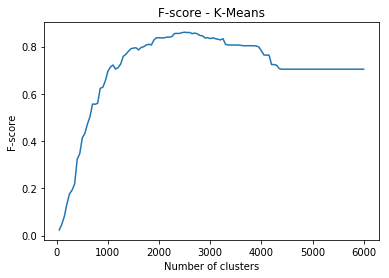

In [82]:
# Plot F-score against number of clusters
plt.plot(list(range(50, 15001, 50)), f_score_kmeans_list)
plt.title('F-score - K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('F-score')
plt.show()

In [ ]:
# Find max F-score and corresponding index
max_score = max(f_score_kmeans_list)
max_index = f_score_kmeans_list.index(max_score)
print("Best F-score: " , max_score)
print("Index of best F-score: ", max_index)

In [ ]:
best_kmeans_model = kmeans_model_list[max_index]

In [ ]:
# Get number of clusters of the best model
best_kmeans_model_num_clusters = best_kmeans_model.n_clusters
best_kmeans_model_labels = best_kmeans_model.labels_
print("Number of clusters of the best k-means model: ", best_kmeans_model_num_clusters)
print("Number of non-empty clusters of the best k-means model: ", len(set(best_kmeans_model.labels_)))

In [ ]:
# save clustered data
path_to_save_data = "appr_5_kmeans_clustered_data.txt"
out_cluster_file = open(path_to_save_data, "a")
for single_label in set(best_kmeans_model_labels):
    indices_label = np.where(best_kmeans_model_labels == single_label)[0].tolist()
    for index in indices_label:
        str_to_save = "[" + str(single_label) + "]:\t\t" + test_steps_df.loc[index]["Key"] + "\t\t" + str(step_id_text_tuple_list[index][0]) + "\t\t"+ str(test_steps_clustering_list[index]) + "\n"
        out_cluster_file.write(str_to_save)
out_cluster_file.close()

In [ ]:
# save cluster labels (step IDs)
path_to_save_labels = "appr_5_kmeans_cluster_labels.txt"
out_cluster_file = open(path_to_save_labels, "a")
for single_label in set(best_kmeans_model_labels):
    indices_label = np.where(best_kmeans_model_labels == single_label)[0].tolist()
    str_to_save = "[" + str(single_label) + "]: " + ','.join(str(step_id_text_tuple_list[x][0]) for x in indices_label) + "\n"
    out_cluster_file.write(str_to_save)
out_cluster_file.close()

In [ ]:
# save list of models and F-score
model_index = 0
kmeans_models_path = "results_approach_5/kmeans_models/"
for kmeans_model in kmeans_model_list:
    pickle.dump(kmeans_model, open(kmeans_models_path + "kmeans_model_" + str(model_index) + ".pkl", "wb"))
    model_index += 1

f_score_list_path = "results_approach_5/appr_5_kmeans_f_scores.txt"
np.savetxt(f_score_list_path, np.asarray(f_score_kmeans_list))